# Notebook description

This notebook looks at the alpha synapse.

# Alpha function

The alpha synapse is so named because it's response to a spike (modeled by a delta function) is the alpha function.

\begin{equation*}
h(t) = \frac{1}{\tau^2}te^{-t/\tau} \quad \textrm{for } t\ge0
\end{equation*}

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

def alpha(t, tau):
    ret = np.zeros_like(t)
    idx = t>=0
    ret[idx] = t[idx]*np.exp(-t[idx]/tau)/tau**2
    return ret

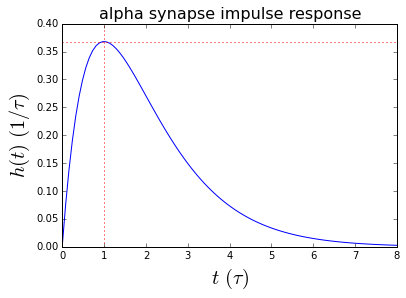

In [2]:
t = np.linspace(0, 8, 100)
h = alpha(t, 1)
plt.plot(t, h)
plt.axvline(1, c='r', ls=':')
plt.axhline(np.exp(-1), c='r', ls=':')
plt.xlabel(r'$t$ $(\tau)$', fontsize=20)
plt.ylabel(r'$h(t)$ $(1/\tau)$', fontsize=20)
plt.title('alpha synapse impulse response', fontsize=16);

Like the first-order synapse (a.k.a. exponential synapse), the alpha synapse also has unit area. To see this,

\begin{align*}
\int_{-\infty}^{\infty}h(t)dt &= \int_{0}^{\infty}\frac{1}{\tau^2}te^{-t/\tau}dt \\
 &= \frac{1}{\tau^2}\int_{0}^{\infty}te^{-t/\tau}dt \\
 &= \frac{1}{\tau^2}\left(\left[-\tau te^{-t/\tau}\right]_0^{\infty}-
    \int_{0}^{\infty}-\tau e^{-t/\tau}dt\right) & \textrm{integration by parts} \\
 &= \frac{1}{\tau^2}\left(0+\tau\int_{0}^{\infty}e^{-t/\tau}dt\right) \\
 &= \frac{1}{\tau^2}\left[-\tau^2e^{-t/\tau}\right]_{0}^{\infty} \\
 &= 1
\end{align*}

# Alpha synapse dynamics

From the impulse response, we can derive the transfer function and differential equation that governs the alpha synapse.

\begin{align*}
H(s) &= \mathcal{L}(h(t)) \\
 &= \frac{1}{\tau^2}\frac{1}{(s+\frac{1}{\tau})^2} \\
 &= \frac{1}{\tau^2}\frac{1}{(\frac{1}{\tau}(\tau s+1))^2} \\
 &= \frac{1}{(\tau s+1)^2} \\
 &= \frac{1}{\tau^2s^2+2\tau s+1} \\
\end{align*}

If we compare this result to the first-order synapse, we see how the alpha synapse arises from arranging two first-order synapses in series.

From the Laplace transform, we can derive the dynamical system

\begin{align*}
H(s) &= \frac{1}{\tau^2s^2+2\tau s+1} \\
\frac{X(s)}{U(s)} &= \frac{1}{\tau^2s^2+2\tau s+1} \\
(\tau^2s^2+2\tau s+1)X(s) &= U(s) \\
 \mathcal{L}&\updownarrow \\
\tau^2\ddot{x}+2\tau\dot{x}+x &= u \\
\end{align*}

Therefore

\begin{equation*}
\ddot{x} = -\frac{2}{\tau}\dot{x}-\frac{1}{\tau^2}x+u
\end{equation*}

We can rewrite this differential equation as a 2D dynamical system by defining state vector $\mathbf{x}=\begin{bmatrix}x_0\\x_1\end{bmatrix}$ and $x_0=\dot{x}$ and $x_1=x$ so that

\begin{align*}
\dot{x_0} &= -\frac{2}{\tau}x_0-\frac{1}{\tau^2}x_1+u \\
\dot{x_1} &= x_0
\end{align*}

\begin{align*}
\dot{
\begin{bmatrix}
x_0 \\ x_1
\end{bmatrix}}
 &=
\begin{bmatrix}
-2/\tau & 1/\tau^2 \\
1 & 0 \\
\end{bmatrix}
\begin{bmatrix}
x_0 \\ x_1
\end{bmatrix}
 +
\begin{bmatrix}
1 \\ 0
\end{bmatrix}
u
\end{align*}


# Appendix

## Derivation verification
Let's verify that the impulse response is consistent with this differential equation.

\begin{align*}
h(t) &= \frac{1}{\tau^2}te^{-t/\tau} \\
\dot{h}(t) &= \frac{1}{\tau^2}\left(e^{-t/\tau}-\frac{1}{\tau}te^{-t/\tau}\right) \\
 &= \frac{1}{\tau^2}e^{-t/\tau}-\frac{1}{\tau^3}te^{-t/\tau} \\
\ddot{h}(t) &= -\frac{1}{\tau^3}e^{-t/\tau}-
    \frac{1}{\tau^3}\left(e^{-t/\tau}-\frac{1}{\tau}te^{-t/\tau}\right) \\
 &= -\frac{2}{\tau^3}e^{-t/\tau}+\frac{1}{\tau^4}te^{-t/\tau} \\
\end{align*}

Now we'll verify that

\begin{align*}
\ddot{h} &= -\frac{2}{\tau}\dot{h}-\frac{1}{\tau^2}h \\
 &=  -\frac{2}{\tau}\left(\frac{1}{\tau^2}e^{-t/\tau}-\frac{1}{\tau^3}te^{-t/\tau}\right)
    -\frac{1}{\tau^2}\frac{1}{\tau^2}te^{-t/\tau} \\
 &= -\frac{1}{\tau^3}e^{-t/\tau}+\frac{1}{\tau^4}te^{-t/\tau} \\
\end{align*}

as we found earlier.